In [1]:
import os
import shutil
import sys
import time
from PIL import Image
from datetime import date, datetime, timedelta


sys.path.insert(0, '..')
from utils import mongodb

In [2]:
from pesagensbalanca import cursor_pesagensbalanca, extract_to

# Gera base de dados de pesagens
Necessário acesso ao Banco de Dados ou ao Servidor

In [3]:
start = datetime(2020, 3, 1)
end = datetime.today()
limit = 10
s0 = time.time()
# cursor = cursor_pesagensbalanca(mongodb, start, end, limit, crop=True)
# count = extract_to(cursor, crop=True)
s1 = time.time()
# print('{:0.2f} segundos para processar {:d} registros'.format((s1 - s0), count))


# Carregar e montar modelo

In [4]:
import pandas as pd
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau



In [5]:
regression_model = models.Sequential([
  layers.Conv2D(16, (7, 7), activation='relu',
                padding='same',
                strides=(2, 2),
                input_shape=(144, 288, 3)),
  layers.MaxPooling2D(pool_size=(2, 4)),
  layers.Dropout(0.25),
  layers.Conv2D(16, (5, 5), 
                strides=(2, 2),
                activation='relu', padding='same'),
  layers.Dropout(0.25),
  layers.Conv2D(16, (5, 5), 
                strides=(2, 2),
                activation='relu'),
  layers.Dropout(0.25),
  layers.AvgPool2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(1)
 
])
regression_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 72, 144, 16)       2368      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 16)        6416      
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          6416      
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 16)          0

In [6]:
for layer in regression_model.layers:
    print(layer, layer.trainable)


<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9329d44d68> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9329ccf390> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329ccf588> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9329ccf6d8> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329ccfb38> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9329ccfc50> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329cdf0f0> True
<tensorflow.python.keras.layers.pooling.AveragePooling2D object at 0x7f9329cdf208> True
<tensorflow.python.keras.layers.core.Flatten object at 0x7f9329cdf400> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9329cdf550> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9329cdf860> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329cdfb70> True
<tensorflow.python.keras.layers.core.Dense objec

# Carregar e montar dados para treinamento

In [7]:
df = pd.read_csv('../../bases/pesagensbalanca/pesos.txt')
df['dif'] = abs(df['pesobalanca'] - df['pesodeclarado'])
df['filename'] = df['id'].map('{}.jpg'.format)
df.head()

,id,pesobalanca,pesodeclarado,dif,filename
0,5e5d096a3d0ec8337863f799,7170,7167,3,5e5d096a3d0ec8337863f799.jpg
1,5e5d09703d0ec8337863f9ee,29190,29149,41,5e5d09703d0ec8337863f9ee.jpg
2,5e5d09703d0ec8337863f9f2,6380,6348,32,5e5d09703d0ec8337863f9f2.jpg
3,5e5d099986556b3036c6dc6d,7610,7788,178,5e5d099986556b3036c6dc6d.jpg
4,5e5d094386556b3036c6dc5c,22280,22300,20,5e5d094386556b3036c6dc5c.jpg


In [8]:
df.describe()

,pesobalanca,pesodeclarado,dif
count,9317.000000,9317.000000,9317.000000
mean,18572.832027,18807.056349,1162.008801
std,8261.590188,8106.655375,3793.829146
min,0.000000,2070.000000,0.000000
25%,11300.000000,11453.000000,72.000000
50%,19600.000000,19960.000000,175.000000
75%,25270.000000,25575.000000,446.000000
max,113350.000000,41388.000000,94730.000000


In [9]:
df[df['dif'] < 4000]['dif'].count() # Pegar somente os pesos que batem declarado x balança

8734

In [10]:
df[df['dif'] < 1000]['dif'].count() # Pegar somente os pesos que batem declarado x balança

8104

In [11]:
df_filtered = df[df['dif'] < 1000]
splitmask = np.random.rand(len(df_filtered)) < 0.9
df_train = df_filtered[splitmask]
df_val = df_filtered[~splitmask]

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='../../bases/pesagensbalanca/pesagensbalanca_cropped',
    target_size=(144, 288),
    batch_size=64,
    x_col='filename',
    y_col="pesobalanca",
    shuffle=False,
    class_mode='raw',
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory='../../bases/pesagensbalanca/pesagensbalanca_cropped',
    target_size=(144, 288),
    batch_size=64,
    x_col='filename',
    y_col="pesobalanca",
    shuffle=False,
    class_mode='raw',
)

Found 7283 validated image filenames.
Found 821 validated image filenames.


# Treinar modelo

In [17]:
regression_model.compile(optimizer=optimizers.Adam(lr=0.002),
                         loss='mean_absolute_error', metrics=['mse', 'mae'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,
                          verbose=1, mode='min')

In [19]:

regression_model.fit(train_generator, epochs=50, shuffle=False,
                     callbacks=[reduce_lr],
                     validation_data = val_generator,
                     validation_steps = val_generator.samples // 64)

Train for 114 steps, validate for 12 steps
Epoch 1/50
114/114 [==============================] - 71s 627ms/step - loss: 5314.6001 - mse: 48031548.0000 - mae: 5314.4102 - val_loss: 4885.2448 - val_mse: 43807472.0000 - val_mae: 4885.2446
Epoch 2/50
114/114 [==============================] - 74s 651ms/step - loss: 4966.2870 - mse: 42782924.0000 - mae: 4966.9834 - val_loss: 4612.6586 - val_mse: 37174208.0000 - val_mae: 4612.6582
Epoch 3/50
114/114 [==============================] - 69s 602ms/step - loss: 4795.7575 - mse: 38960172.0000 - mae: 4795.6753 - val_loss: 4382.1956 - val_mse: 32754432.0000 - val_mae: 4382.1958
Epoch 4/50
114/114 [==============================] - 71s 625ms/step - loss: 4483.6089 - mse: 34356420.0000 - mae: 4483.6729 - val_loss: 4176.7559 - val_mse: 30156878.0000 - val_mae: 4176.7563
Epoch 5/50
114/114 [==============================] - 72s 634ms/step - loss: 4349.6299 - mse: 32278584.0000 - mae: 4349.6362 - val_loss: 4097.2538 - val_mse: 29485046.0000 - val_mae: 40

114/114 [==============================] - 69s 608ms/step - loss: 3628.2092 - mse: 24159418.0000 - mae: 3627.4285 - val_loss: 3610.2058 - val_mse: 23325040.0000 - val_mae: 3610.2061
Epoch 41/50
114/114 [==============================] - 68s 599ms/step - loss: 3642.8277 - mse: 23990684.0000 - mae: 3642.8516 - val_loss: 3590.9073 - val_mse: 23258506.0000 - val_mae: 3590.9075
Epoch 42/50
114/114 [==============================] - 68s 594ms/step - loss: 3659.0037 - mse: 23798820.0000 - mae: 3658.4138 - val_loss: 3538.6688 - val_mse: 23062282.0000 - val_mae: 3538.6687
Epoch 43/50
114/114 [==============================] - 68s 595ms/step - loss: 3659.1972 - mse: 24209062.0000 - mae: 3658.8608 - val_loss: 3573.5027 - val_mse: 23232646.0000 - val_mae: 3573.5027
Epoch 44/50
114/114 [==============================] - 70s 612ms/step - loss: 3678.3464 - mse: 24285356.0000 - mae: 3678.2192 - val_loss: 3552.7615 - val_mse: 23139678.0000 - val_mae: 3552.7617
Epoch 45/50
113/114 [=====================

In [20]:
#regression_model.save_weights('gerabasespesagens_cropped2.hdf5')

In [66]:
regression_model.load_weights('gerabasespesagens_cropped2.hdf5')

## Fine tunning

In [25]:
for layer in regression_model.layers:
    layer.trainable = True
for layer in regression_model.layers[:-4]:
    layer.trainable = False
for layer in regression_model.layers:
    print(layer, layer.trainable)


<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9329d44d68> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9329ccf390> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329ccf588> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9329ccf6d8> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329ccfb38> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9329ccfc50> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329cdf0f0> False
<tensorflow.python.keras.layers.pooling.AveragePooling2D object at 0x7f9329cdf208> False
<tensorflow.python.keras.layers.core.Flatten object at 0x7f9329cdf400> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f9329cdf550> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9329cdf860> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329cdfb70> True
<tensorflow.python.keras.layers.core.De

In [30]:
regression_model.compile(optimizer=optimizers.SGD(lr=0.001),
                         loss='mean_squared_logarithmic_error', metrics=['msle', 'mae', 'mse'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                          verbose=1, mode='min')

In [28]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='../../bases/pesagensbalanca/pesagensbalanca_cropped',
    target_size=(144, 288),
    batch_size=128,
    x_col='filename',
    y_col="pesobalanca",
    shuffle=False,
    class_mode='raw',
)


Found 7283 validated image filenames.


In [31]:
regression_model.fit(train_generator, epochs=20, shuffle=False,
                     callbacks=[reduce_lr],
                     validation_data = val_generator,
                     validation_steps = val_generator.samples // 64)

Train for 57 steps, validate for 12 steps
Epoch 1/20
57/57 [==============================] - 71s 1s/step - loss: 0.0947 - msle: 0.0947 - mae: 3608.4629 - mse: 23316486.0000 - val_loss: 0.1091 - val_msle: 0.1091 - val_mae: 3562.4495 - val_mse: 23320314.0000
Epoch 2/20
57/57 [==============================] - 71s 1s/step - loss: 0.0960 - msle: 0.0960 - mae: 3634.3882 - mse: 23902398.0000 - val_loss: 0.1093 - val_msle: 0.1093 - val_mae: 3560.1953 - val_mse: 23409062.0000
Epoch 3/20
57/57 [==============================] - 69s 1s/step - loss: 0.0959 - msle: 0.0959 - mae: 3642.7004 - mse: 23762100.0000 - val_loss: 0.1079 - val_msle: 0.1079 - val_mae: 3559.0322 - val_mse: 23223136.0000
Epoch 4/20
57/57 [==============================] - 68s 1s/step - loss: 0.0953 - msle: 0.0953 - mae: 3632.0486 - mse: 23893478.0000 - val_loss: 0.1082 - val_msle: 0.1082 - val_mae: 3570.1289 - val_mse: 23299914.0000
Epoch 5/20
57/57 [==============================] - 88s 2s/step - loss: 0.0955 - msle: 0.0955 

In [67]:
regression_model.compile(optimizer=optimizers.SGD(lr=0.0001),
                         loss='mean_absolute_error', metrics=['msle', 'mae', 'mse'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                          verbose=1, mode='min')

In [68]:
regression_model.fit(train_generator, epochs=20, shuffle=False,
                     callbacks=[reduce_lr],
                     validation_data = val_generator,
                     validation_steps = val_generator.samples // 64)

Train for 57 steps, validate for 12 steps
Epoch 1/20
57/57 [==============================] - 68s 1s/step - loss: 5622.2075 - msle: 0.1992 - mae: 5624.1997 - mse: 55791784.0000 - val_loss: 3756.6118 - val_msle: 0.1211 - val_mae: 3756.6116 - val_mse: 26991670.0000
Epoch 2/20
57/57 [==============================] - 69s 1s/step - loss: 4039.2813 - msle: 0.1083 - mae: 4039.6230 - mse: 28704642.0000 - val_loss: 3569.9286 - val_msle: 0.1115 - val_mae: 3569.9285 - val_mse: 23872918.0000
Epoch 3/20
57/57 [==============================] - 68s 1s/step - loss: 3988.0034 - msle: 0.1053 - mae: 3987.5867 - mse: 27424336.0000 - val_loss: 3688.5720 - val_msle: 0.1213 - val_mae: 3688.5723 - val_mse: 26035480.0000
Epoch 4/20
57/57 [==============================] - 67s 1s/step - loss: 3891.8890 - msle: 0.1026 - mae: 3891.7432 - mse: 26609566.0000 - val_loss: 3542.2460 - val_msle: 0.1098 - val_mae: 3542.2463 - val_mse: 23128936.0000
Epoch 5/20
57/57 [==============================] - 67s 1s/step - loss

In [110]:
regression_model.save_weights('gerabasespesagens_cropped2_finetunning.h5')

# Avaliação

27005.736 33080


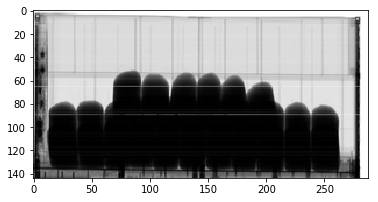

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
sample = df.sample()
filename = sample['filename'].item()
image = Image.open('../../bases/pesagensbalanca/pesagensbalanca_cropped/' + filename)
image = image.resize((288, 144), Image.LANCZOS)
image_array = np.expand_dims(np.array(image), axis=0) / 255
print(regression_model.predict(image_array)[0][0], sample['pesobalanca'].item())
plt.imshow(image)

In [77]:
y_preds_train = regression_model.predict_generator(train_generator)

In [78]:
y_preds_val = regression_model.predict_generator(val_generator)

In [79]:
y_preds_val

array([[ 6538.6704],
       [13871.25  ],
       [21020.834 ],
       [25824.309 ],
       [25157.842 ],
       [25276.031 ],
       [25443.627 ],
       [25259.895 ],
       [12617.661 ],
       [10279.668 ],
       [26854.678 ],
       [21940.8   ],
       [21770.543 ],
       [23646.258 ],
       [19837.63  ],
       [24095.764 ],
       [ 8858.457 ],
       [20432.658 ],
       [26490.451 ],
       [25442.19  ],
       [25216.484 ],
       [20608.164 ],
       [28917.5   ],
       [23866.887 ],
       [25491.14  ],
       [21208.648 ],
       [18805.682 ],
       [14859.157 ],
       [ 7197.9536],
       [23698.812 ],
       [ 9212.141 ],
       [11088.537 ],
       [26690.47  ],
       [24804.396 ],
       [28298.07  ],
       [ 5434.56  ],
       [15902.843 ],
       [12628.849 ],
       [ 8763.088 ],
       [18327.2   ],
       [24499.793 ],
       [ 5597.6562],
       [ 8012.284 ],
       [ 7736.317 ],
       [23927.393 ],
       [22423.717 ],
       [13215.214 ],
       [15298

In [80]:
df_val.shape

(821, 7)

In [81]:
y_preds_val.shape

(821, 1)

In [82]:
df_val['preds'] = y_preds_val

/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [84]:
df_val.head()

,id,pesobalanca,pesodeclarado,dif,filename,preds,dif_pred
0,5e5d096a3d0ec8337863f799,7170,7167,3,5e5d096a3d0ec8337863f799.jpg,6538.670410,878.515137
14,5e5d09703d0ec8337863f9fe,11680,11705,25,5e5d09703d0ec8337863f9fe.jpg,13871.250000,2084.910156
23,5e5d09693d0ec8337863f703,24260,24156,104,5e5d09693d0ec8337863f703.jpg,21020.833984,3429.355469
47,5e5d096c3d0ec8337863f805,25740,25825,85,5e5d096c3d0ec8337863f805.jpg,25824.308594,119.167969
59,5e5d096c3d0ec8337863f809,12470,12563,93,5e5d096c3d0ec8337863f809.jpg,25157.841797,11524.681641


In [85]:
df_val['dif_pred'] = abs(df_val['pesobalanca'] - df_val['preds'])

/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [86]:
df_val.describe()

,pesobalanca,pesodeclarado,dif,preds,dif_pred
count,821.000000,821.000000,821.000000,821.000000,821.000000
mean,18672.019488,18689.483557,198.855055,18566.238281,3560.715656
std,8003.655553,7984.234718,194.378396,6607.412598,3308.199097
min,2210.000000,2527.000000,0.000000,5242.412598,1.658203
25%,11260.000000,11436.000000,56.000000,13366.061523,1102.654297
50%,20070.000000,19961.000000,133.000000,20425.548828,2646.953125
75%,25080.000000,25108.000000,280.000000,23933.589844,4899.012695
max,33720.000000,33840.000000,954.000000,29755.142578,23745.451172


In [87]:
np.bincount(pd.np.digitize(df_val['dif_pred'], bins = [1000, 2000, 3000, 4000, 24000]))

array([183, 153, 103, 114, 268])

In [88]:
sum(df_val.dif_pred > 4000)

268

In [89]:
df_train['preds'] = y_preds_train

/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [90]:
df_train['dif_pred'] = abs(df_train['pesobalanca'] - df_train['preds'])

/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [91]:
df_train.describe()

,pesobalanca,pesodeclarado,dif,preds,dif_pred
count,7283.000000,7283.000000,7283.000000,7283.000000,7283.000000
mean,18788.154469,18813.464232,216.550460,18516.132812,3246.304222
std,7986.566802,7964.783981,209.536006,6645.578613,3002.994304
min,2370.000000,2211.000000,0.000000,3793.148682,0.507812
25%,11590.000000,11592.000000,62.000000,12535.391602,1022.928223
50%,19870.000000,19850.000000,143.000000,20746.548828,2444.554688
75%,25400.000000,25452.000000,308.000000,24080.070312,4481.205566
max,34500.000000,33972.000000,999.000000,30071.160156,25037.117676


In [59]:
np.bincount(pd.np.digitize(df_train['dif_pred'], bins = [1000, 2000, 3000, 4000, 24000]))

array([1768, 1360, 1093,  874, 2187,    1])

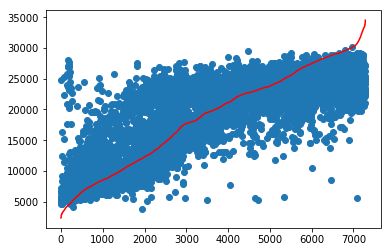

In [107]:
df_sorted = df_train.sort_values(by='pesobalanca')
x = range(len(df_sorted))
plt.scatter(x=x, y=list(df_sorted.preds))
plt.plot(list(df_sorted.pesobalanca), color='r')


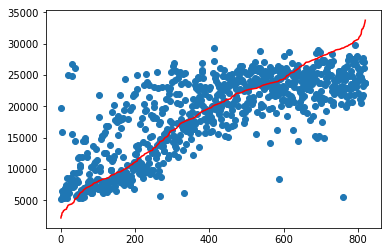

In [108]:
df_sorted = df_val.sort_values(by='pesobalanca')
x = range(len(df_sorted))
plt.scatter(x=x, y=list(df_sorted.preds))
plt.plot(list(df_sorted.pesobalanca), color='r')

Os gráficos sugerem que os maiores erros estão nas cargas com peso de balança menor que 10.000 ou maiores que 30.000.

Isto parece explicitar erros ou fraudes na base. Assim, seria interessante rodar novamente eliminando exemplos em que o erro esteja muito alto ou o peso esteja muito alto ou muito baixo.

In [144]:
df_final = pd.concat((df_train, df_val))
df_final.shape

(8104, 7)

In [146]:
df_final_filtered = df_final[
    (df_final.pesobalanca > 1000) &
    (df_final.pesobalanca < 30000) &
    (df_final.dif_pred < 6000)]

df_final_filtered.shape

(6652, 7)

In [148]:
df_final_filtered.to_pickle('df_final_filtered_pesagensbalanca.pkl')

(8104, 7)

(2086, 7)